In [1]:
import enchant
import numpy as np
import pandas as pd

from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# What are we loading into memory and working with?

We are working with a dataset that is analyzing whether a given SMS text message is spam, denoted 'spam', or not, denoted 'ham'. The text, and the classification, are the only two file attributes.

Lets load the dataset into memory, and take a look at it.

In [2]:
#Reading in 'Spam SMS' dataset into memory
spamPath = '/home/samsuri/DataSets/SmsSpam/spam.csv'
#Latin encoding must be used, invalid encoding for utf-8
df = pd.read_csv(spamPath, encoding="latin", usecols=[0,1], names=['classification', 'text'], skiprows=1)
#Lowercasing all text in 'text' column
df['text'] = df['text'].str.lower()

In [3]:
#Looking at our data
df.head(10)

,classification,text
0,ham,"go until jurong point, crazy.. available only ..."
1,ham,ok lar... joking wif u oni...
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor... u c already then say...
4,ham,"nah i don't think he goes to usf, he lives aro..."
5,spam,freemsg hey there darling it's been 3 week's n...
6,ham,even my brother is not like to speak with me. ...
7,ham,as per your request 'melle melle (oru minnamin...
8,spam,winner!! as a valued network customer you have...
9,spam,had your mobile 11 months or more? u r entitle...


# Lets see how some common algorithms perform?

Lets first investigate the performance of some common algorithms:
- MultinomialNB
- Logistic Regression
- Support Vector Machine
- Random Forest

Given that we are doing binary classification, logistic regression, should be included. For all algorithms, the text will tokenized into words, using a bag-of-words approach.

In [4]:
#List of all SMS texts
documentList = df['text']
vect = CountVectorizer()
#Frequency count matrix of all words in SMS texts
countMatrix = vect.fit_transform(documentList)
tokenizedDf = pd.DataFrame(countMatrix.toarray(), columns=vect.get_feature_names())

#Encoding SMS texts for ML algorithms
resultEncodingDict = {'ham': 1, 'spam': 0}
resultList = df['classification']
resultList.replace(resultEncodingDict, inplace=True)
xTrain, xTest, yTrain, yTest = train_test_split(tokenizedDf, resultList, test_size=.3, random_state=123)

### MultinomialNB

In [5]:
mnb = MultinomialNB()
mnb.fit(xTrain, yTrain)
accuracy_score(yTest, mnb.predict(xTest))*100

98.14593301435407

### Logistic Regression

In [6]:
lr = LogisticRegression()
lr.fit(xTrain, yTrain)
accuracy_score(yTest, lr.predict(xTest))*100

/home/samsuri/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


98.26555023923444

### Support Vector Machine

In [7]:
svc = SVC(gamma='auto')
svc.fit(xTrain, yTrain)
accuracy_score(yTest, svc.predict(xTest))*100

87.14114832535886

## Preliminary Results

Clearly, MultinomialNB and Logistic Regression did the best, whereas SVC did the worst. This is most likely because though the data is in a very high dimension, given that the number of columns is established over the entire vocabulary of the 'text' column, it not not easily seperatable, regardless of the kernal used.

Also, because an optimum soft margin had to be found, SVC was the slowest of the methods.

MultinomialNB did very well considering its speed and simplicity. It was particularly well suited for the bag-of-words technique on the text data.

# Can we do better?
## Lets Strip out words that are not valid English
Our best result was 98.27% accuracy by using logistic regression. Can we do better? By striping out words that are not valid English, such as numbers, slang, and giberish, we can isolate words that ideally we derive more meaning from.

For example, the word 'free' might be significant, though its weight is diluted when there are many other words. Lets see the effect of only including valid English words...

In [126]:
#Establishing a set of all valid words in the English dictionary
dictionary = enchant.Dict('en_US')

#New dataframe will have only valid English words
#along with bools to represent '!' and '?' being present or not 
exclaimMark = []
questionMark = []
cleanedText = []
for index, row in df.iterrows():
    tempList = []
    #Tokenizing text in each row of dataframe
    tokenList = word_tokenize(row['text'])
    
    exclaimBool = 0
    questionBool = 0
    for possibleWord in tokenList:
        #Seeing if '!' is present
        if possibleWord == '!':
            exclaimBool = 1
        #Seeing if '?' is present
        elif possibleWord == '?':
            questionBool = 1
        #Seeing if each words in SMS text is in NTLK dictionary
        elif dictionary.check(possibleWord) == True:
            if (len(possibleWord) == 1) and (possibleWord not in ['a', 'A', 'i', 'I']):
                continue
            else:
                tempList.append(possibleWord)
    
    exclaimMark.append(exclaimBool)
    questionMark.append(questionBool)
    cleanedText.append(' '.join(tempList))

In [127]:
#Rebuilding frequency count matrix for SMS text
dictVect = CountVectorizer()
dictCountMatrix = dictVect.fit_transform(cleanedText)

#Converting frequency count matrix to numpy array
#Converting lists to numpy array
dictCountMatrix = dictCountMatrix.toarray()
exclaimMarkArr = np.array([exclaimMark])
questionMarkArr = np.array([questionMark])

#Concatinating numpy arrays along vertical axis
dictMatrix = np.concatenate([dictCountMatrix, exclaimMarkArr.T, questionMarkArr.T], axis=1)

#Adding new columns in order columns were concatinated
dictColumns = dictVect.get_feature_names() + ['Exclamation'] + ['Question']
dictionaryDf = pd.DataFrame(dictMatrix, columns=dictColumns)

In [128]:
#Looking at our data, where the text is only valid English
data = [(cleanedText[i], exclaimMark[i], questionMark[i]) for i in range(len(cleanedText))]
unsplitDf = pd.DataFrame(data, columns = ['Text', 'ExclamationMark', 'QuestionMark'])
unsplitDf.head(20)

,Text,ExclamationMark,QuestionMark
0,"jurong , bugis amore wat",0,0
1,ok lar wif oni,0,0
2,tkts ( txt ) & 's 08452810075over18 's,0,0
3,hor,0,0
4,"n't usf ,",0,0
5,"freemsg 's 's 'd ok chgs , å£1.50 rcv",1,1
6,,0,0
7,'melle melle ( oru minnaminunginte nurungu vet...,0,0
8,receivea å£900 kl341,1,0
9,colour,1,1


In [129]:
#Looking at our data, when the text is tokenized with frequency counts
dictionaryDf.head(10)

,00,000,000pes,02,03,04,0430,05,06,07,...,û_thanks,ûªm,ûªt,ûªve,ûï,ûïharry,ûò,ûówell,Exclamation,Question
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


## Now, lets re-run our tests

In [130]:
xTrain, xTest, yTrain, yTest = train_test_split(dictMatrix, resultList, test_size=.3, random_state=123)

## MultinomialNB

In [131]:
mnb = MultinomialNB()
mnb.fit(xTrain, yTrain)
accuracy_score(yTest, mnb.predict(xTest))*100

96.5311004784689

## Logistic Regression

In [132]:
lr = LogisticRegression()
lr.fit(xTrain, yTrain)
accuracy_score(yTest, lr.predict(xTest))*100

/home/samsuri/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


95.51435406698565

# Lets do a Principal Component Analysis

Our accuracy actually went down, for MultinomialNB, by .478%, and for Logistic Regression, by .24%. That means we eliminated some key columns when filtering out non-valid English words. Lets see if by using PCA, we can see if any columns are highly relevent...

In [119]:
#Numpy array of frequency counts on tokenized SMS texts
frequencyCounts = tokenizedDf.values
#Encoded 'spam'/'ham' Series
encodedClassication = resultList.values

In [120]:
#Standardizing frequency count matrix
standardizedFreqCounts = StandardScaler().fit_transform(frequencyCounts)

In [121]:
#Only looking at PC1 and PC2
pca = PCA(n_components=2)
princComp = pca.fit_transform(standardizedFreqCounts)

In [122]:
#Concatinating pc1, pc2, and encoded classification array
princDf = pd.DataFrame(princComp, columns=['pc1', 'pc2'])
mergedPrincDf = pd.concat([princDf, pd.Series(encodedClassication, name='classification')], axis=1)
mergedPrincDf.head()

,pc1,pc2
0,-0.113019,-0.325890
1,-0.084644,-0.339417
2,-0.179895,-0.450165
3,-0.089110,-0.205986
4,-0.022884,0.027842


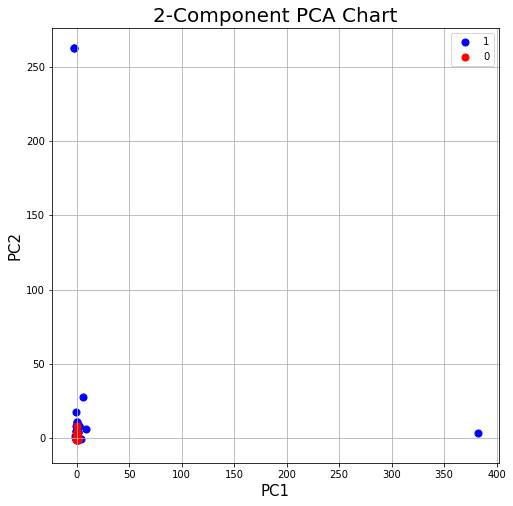

In [133]:
#Plotting data, to get a visual representation
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
#Adding x and y labels
ax.set_xlabel('PC1', fontsize=15)
ax.set_ylabel('PC2', fontsize=15)
#Adding title
ax.set_title('2-Component PCA Chart', fontsize=20)

classifications = [1, 0]
colors = ['b', 'r']
#Plotting scatter graph
for classification, color in zip(classifications, colors):
    indicesToKeep = mergedPrincDf['classification'] == classification
    ax.scatter(mergedPrincDf.loc[indicesToKeep, 'pc1'], 
               mergedPrincDf.loc[indicesToKeep, 'pc2'], 
               c=color, s=50)
    
ax.legend(classifications)
ax.grid()

In [145]:
#Looking at varience each explained by PC1 and PC2
pc1Var, pc2Var = pca.explained_variance_ratio_
print(f'Varience explained by pc1 is: {pc1Var*100:.3f}%')
print(f'Varience explained by pc2 is: {pc2Var*100:.3f}%')

Varience explained by pc1 is: 0.304%
Varience explained by pc2 is: 0.293%


## PCA does not yield many answers

As we can see, performing a Principal Component Analysis is not effective at all on finding a particular dimension that carries more weight than any other, this makes sense given that each SMS text has so many words in them.

# Lets investigate some keywords that may be of interest

By looking at specific words, such as 'free' and 'winning', we might be able to increase the chance that PCA will find a dimension that demonstrates high variability. Lets investigate...

In [169]:
freeBool = []
winBool = []
interestedBool = []
buyBool = []
dollarSignBool = []
offerBool = []

keyWordDict = {'free': freeBool, 'win': winBool, 'interested': interestedBool, 'buy': buyBool, 
               '$': dollarSignBool, 'offer': offerBool}

for index, row in df.iterrows():
    for keyWord, keyList in keyWordDict.items():
        if keyWord in row.text:
            keyList.append(1)
        else:
            keyList.append(0)

In [170]:
keyWordDf = pd.DataFrame(list(zip(freeBool, winBool, interestedBool, buyBool, 
                          dollarSignBool, offerBool, exclaimMark, questionMark)),
                          columns=['Free', 'Win', 'Interested', 'Buy', 'DollarSign',
                                  'Offer', 'Exlamaition', 'Question'])

keyWordDf.head()

,Free,Win,Interested,Buy,DollarSign,Offer,Exlamaition,Question
0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0


In [171]:
standardizedFreqCounts = StandardScaler().fit_transform(keyWordDf)

In [172]:
#Only looking at PC1 and PC2
pca = PCA(n_components=2)
princComp = pca.fit_transform(standardizedFreqCounts)

In [173]:
#Concatinating pc1, pc2, and encoded classification array
princDf = pd.DataFrame(princComp, columns=['pc1', 'pc2'])
mergedPrincDf = pd.concat([princDf, pd.Series(encodedClassication, name='classification')], axis=1)
mergedPrincDf.head()

,pc1,pc2,classification
0,-0.474373,-0.162376,1
1,-0.474373,-0.162376,1
2,4.619581,1.386276,0
3,-0.474373,-0.162376,1
4,-0.474373,-0.162376,1


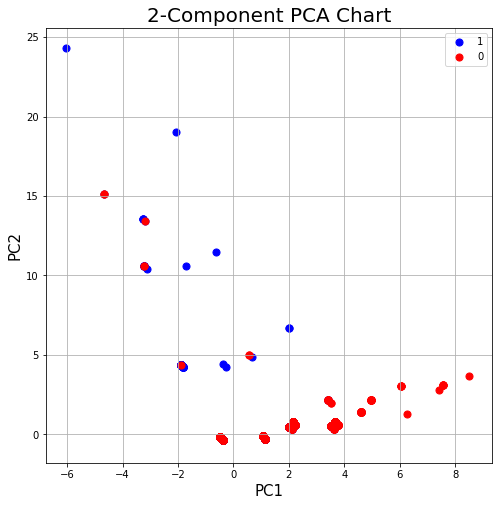

In [174]:
#Plotting data, to get a visual representation
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
#Adding x and y labels
ax.set_xlabel('PC1', fontsize=15)
ax.set_ylabel('PC2', fontsize=15)
#Adding title
ax.set_title('2-Component PCA Chart', fontsize=20)

classifications = [1, 0]
colors = ['b', 'r']
#Plotting scatter graph
for classification, color in zip(classifications, colors):
    indicesToKeep = mergedPrincDf['classification'] == classification
    ax.scatter(mergedPrincDf.loc[indicesToKeep, 'pc1'], 
               mergedPrincDf.loc[indicesToKeep, 'pc2'], 
               c=color, s=50)
    
ax.legend(classifications)
ax.grid()

In [175]:
#Looking at varience each explained by PC1 and PC2
pc1Var, pc2Var = pca.explained_variance_ratio_
print(f'Varience explained by pc1 is: {pc1Var*100:.3f}%')
print(f'Varience explained by pc2 is: {pc2Var*100:.3f}%')

Varience explained by pc1 is: 15.412%
Varience explained by pc2 is: 14.176%
